In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from pylab import *

In [2]:
from IPython.display import display, Math, Latex

# 决策边界

考虑如下由k个线性函数组成的K-class 判别式：

$y_k(\mathbf{x})=\mathbf{w_k}^T\mathbf{x}+w_{k0} $

如果对于所有的$j\neq k $ ,有$y_k(\mathbf{x})>y_j(\mathbf{x}) $ ,那么将将x分到类别k。
由此我们知道类$C_k$和类$C_j$之间的决策边界为$y_k(\mathbf{x})=y_j(\mathbf{x}) $,对应于一个(D-1)维超平面：
 $(\mathbf{w}_k − \mathbf{w}_j)^T\mathbf{x} + (w_{k0} − w_{j0}) = 0$.
 
 如果为二元分类,每个类别的维度为2(在一个二维平面上)，输入$\mathbf{x}=(x1,x2)^T$,有$(\mathbf{w}_1-\mathbf{w}_2)=(a,b)^T$,那么有$(a,b)(x1,x2)^T+(w_{10} − w_{00})=0$变为：
 ax1+bx2+c=0
 
 $x2=-\frac{b}{a}x1-\frac{c}{b}$
 
 


In [3]:
"""4.1.3 用于分类的最小平方方法 P.184"""

K = 2    # 类别的数目
N = 100  # 总的数据点的数目

def f(x1, W_t):
    # 决策边界的直线方程
    
    a = - ((W_t[0,1] - W_t[1,1]) / (W_t[0,2] - W_t[1,2]))
    b = - (W_t[0,0] - W_t[1,0]) / (W_t[0,2] - W_t[1,2])
    return a * x1 + b


# 两个类别的训练数据
cls1 = []
cls2 = []

# 数据由正态分布生成
mean1 = [-1, 2]  # 类别1的均值
mean2 = [1, -1]  # 类别2的均值
cov = [[1.0,0.8], [0.8,1.0]]  # 所有类别的协方差矩阵

# 无噪音数据
cls1.extend(np.random.multivariate_normal(mean1, cov, N / 2))
cls2.extend(np.random.multivariate_normal(mean2, cov, N / 2))


In [108]:
# 通过最小二乘法计算参数矩阵W（公式4.16 ）
def least_squares_classification_boundary_plot(classes):
    #classes 是一个数组[cls1,cls2,cls3,...]，元素为包含输入的数组 clsn=[[2.34,4.56],[4.12,6.31]]
    temp = vstack(classes)
    sample_number_of_each_class=map(len,classes)
    totalSamples=sum(sample_number_of_each_class)
    

    temp2 = ones((totalSamples, 1)) # 添加偏置W_0
    X = hstack((temp2, temp))

    # 创建一个target矩阵T (1-of-K 表示方法)
    T = zeros((totalSamples,len(classes)))
    
    for i in xrange(len(classes)):
        class_start_index=int(sum(sample_number_of_each_class[:i])) 
        class_end_index=int(sum(sample_number_of_each_class[:i+1])) 
        T[class_start_index:class_end_index,i]=1
        
    
    X_t = np.transpose(X)
    temp = np.linalg.inv(np.dot(X_t, X))  # 矩阵的乘积是np.dot （ A，B）
    W = np.dot(np.dot(temp, X_t), T)
    W_t = np.transpose(W)

    colors=('r','b','y','g','g','c')
    getColors=(color for color in colors)
    # 绘制训练数据
    for i,cls in enumerate(classes):
        x1, x2 = np.transpose(np.array(cls))
        plot(x1, x2, '%so'%colors[i])
    
    xlim(-4, 13)
    ylim(-8, 6)
    
    
    # 绘制决策边界
    if len(classes)==3:
        x1=np.linspace(-4,13,1000)
        y_max=ones_like(x1)*6
        y_min=-8*ones_like(x1)
        boundry_1_2=[f(x, W_t[[0,1],:]) for x in x1]
        boundry_1_3=[f(x, W_t[[0,2],:]) for x in x1]
        boundry_2_3=[f(x, W_t[[1,2],:]) for x in x1]
        boundry_1=np.maximum(boundry_1_2,boundry_1_3)
        boundry_3=np.minimum(boundry_1_3,boundry_2_3)
        plt.fill_between(x1, boundry_1, y_max, color='b', alpha='0.1')
        plt.fill_between(x1, boundry_3, y_min, color='g', alpha='0.1')
        #plot(x1, boundry_1, '%sx'%getColors.next())
        #plot(x1, boundry_3, '%sx'%getColors.next())    
    
    for i in xrange(len(classes)):
        for j in xrange(i+1,len(classes)):
            x1 = np.linspace(-4, 13, 1000)
            x2 = [f(x, W_t[[i,j],:]) for x in x1]
            plot(x1, x2, '%s-'%getColors.next())
    
    

    
    show()

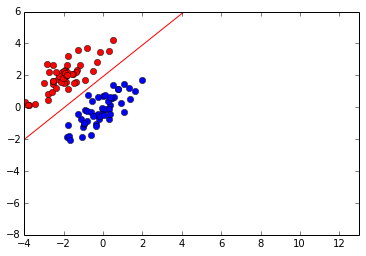

In [109]:
least_squares_classification_boundary_plot([cls1,cls2])

## 由于最小平方用于分类是得到精确的解析解，所以其对于异常点非常敏感，这一点与logistic回归模型有所不同

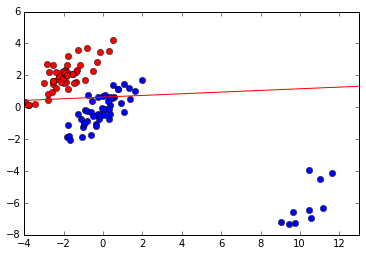

In [110]:
#
cls2_noise=np.random.multivariate_normal([10,-6], [[0.8,0.8], [0.3,0.8]], 10)
cls3=vstack((cls2,cls2_noise))

least_squares_classification_boundary_plot([cls1,cls3])

# 多分类

现在考虑把线性判别函数推广到K > 2个类别。我们可能会尝试把多个二分类判别函数结合 起来,构造一个K类判别函数。但是,这会产生一些严重的困难(Duda and Hart, 1973),正如 我们马上要说明的那样。
考虑使用K−1个分类器,每个分类器用来解决一个二分类问题,把属于类别$C_k$和不属于类别$C_k$的点分开。这被称为“1对其他”(one-versus-the-rest)分类器。图4.2的左侧给出了一个涉 及到三个类别的例子。这个例子中,这种方法产生了输入空间中无法分类的区域。
另一种方法是引入K(K−1)/2个二元判别函数,对每一对类别都设置一个判别函数。这被称
为“1对1”(one-versus-one)分类器。这样,每个点的类别根据这些判别函数中的大多数输出类 别确定。但是,这也会造成输入空间中的无法分类的区域,如图4.2右侧的图所示。
通过引入一个K 类判别函数,我们可以避免这些问题。这个K 类判别函数由K 个线性函数组
成
考虑如下由k个线性函数组成的K-class 判别式：

$y_k(\mathbf{x})=\mathbf{w_k}^T\mathbf{x}+w_{k0} $

如果对于所有的$j\neq k $ ,有$y_k(\mathbf{x})>y_j(\mathbf{x}) $ ,那么将将x分到类别k。
由此我们知道类$C_k$和类$C_j$之间的决策边界为$y_k(\mathbf{x})=y_j(\mathbf{x}) $,对应于一个(D-1)维超平面：
 $(\mathbf{w}_k − \mathbf{w}_j)^T\mathbf{x} + (w_{k0} − w_{j0}) = 0$.


# 注意对于多个类别来说，这些决策边界是通过同一个点的

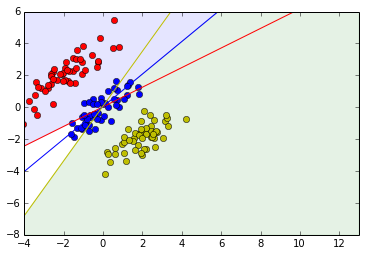

In [113]:
K = 3    # 3クラス分類
N = 150  # データ数
def f1(x1, W_t):
    # クラス1とクラス2の決定境界の直線の方程式
    a = - ((W_t[0,1] - W_t[1,1]) / (W_t[0,2] - W_t[1,2]))
    b = - ((W_t[0,0] - W_t[1,0]) / (W_t[0,2] - W_t[1,2]))
    return a * x1 + b

def f2(x1, W_t):
    # クラス2とクラス3の決定境界の直線の方程式
    a = - ((W_t[1,1] - W_t[2,1]) / (W_t[1,2] - W_t[2,2]))
    b = - ((W_t[1,0] - W_t[2,0]) / (W_t[1,2] - W_t[2,2]))
    return a * x1 + b

cls1 = []
cls2 = []
cls3 = []

mean1 = [-2, 2]  # クラス1の平均
mean2 = [0, 0]   # クラス2の平均
mean3 = [2, -2]  # クラス3の平均
cov = [[1.0,0.8], [0.8,1.0]]  # 共分散行列（全クラス共通）

# データを作成
cls1.extend(np.random.multivariate_normal(mean1, cov, N / 3))
cls2.extend(np.random.multivariate_normal(mean2, cov, N / 3))
cls3.extend(np.random.multivariate_normal(mean3, cov, N / 3))

least_squares_classification_boundary_plot([cls1,cls2,cls3])

## 上图是一个三个类别的边界情况
   类别1，类别2===>红色
   
   类别1，类别3===>绿色
   
   类别2，类别3===>黄色，
   
对于类别1来说，红色的左侧和绿色的左侧是其决策区域
对于类别3来说，绿色的右侧和黄色的右侧是其决策区域
对于类别2来说，红色和黄色围成的剩下的区域为其决策区域

1 [ 0.9        -0.65824343  1.22471538]
2 [ 0.9        -0.65824343  1.22471538]


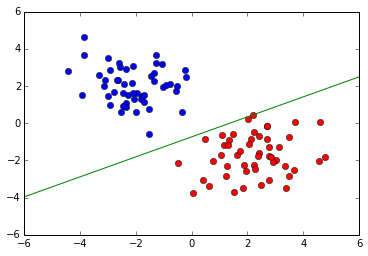

In [114]:

N = 100
ETA = 0.1

# 訓練データを作成
cls1 = []
cls2 = []
t = []

# データは正規分布に従って生成
mean1 = [-2, 2]    # クラス1の平均
mean2 = [2, -2]    # クラス2の平均
cov = [[1.0, 0.0], [0.0, 1.0]]  # 共分散行列（全クラス共通）

# データ作成
cls1.extend(np.random.multivariate_normal(mean1, cov, N / 2))
cls2.extend(np.random.multivariate_normal(mean2, cov, N / 2))

# 教師データ
for i in range(N / 2):
    t.append(+1)  # クラス1
for i in range(N/2):
    t.append(-1)  # クラス2

# 訓練データを描画
# クラス1
x1, x2 = np.transpose(np.array(cls1))
plot(x1, x2, 'bo')

# クラス2
x1, x2 = np.transpose(np.array(cls2))
plot(x1, x2, 'ro')

# クラス1とクラス2のデータをマージ
x1, x2 = np.array(cls1+cls2).transpose()

# 確率的最急降下法でパラメータwを更新
w = array([1.0, 1.0, 1.0])  # 適当な初期値

turn = 0
correct = 0  # 分類が正解したデータ数
while correct < N:  # 全部のデータが正しく分類できるまで続ける
    correct = 0
    for i in range(N):  # 全データについて検討
        if np.dot(w, [1, x1[i], x2[i]]) * t[i] > 0:  # 分類が正しいときは何もしない
            correct += 1
        else:  # 分類が間違っているときは重みを調整
            w += ETA * array([1, x1[i], x2[i]]) * t[i]
    turn += 1
    print turn, w

# 決定境界を描画
x = linspace(-6.0, 6.0, 1000)
y = -w[1] / w[2] * x - w[0] / w[2]
plot(x, y, 'g-')

xlim(-6, 6)
ylim(-6, 6)
show()

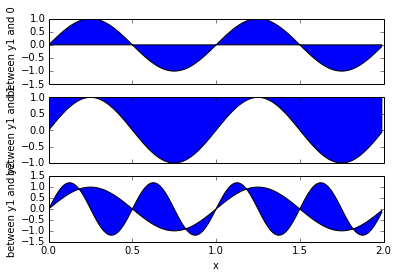

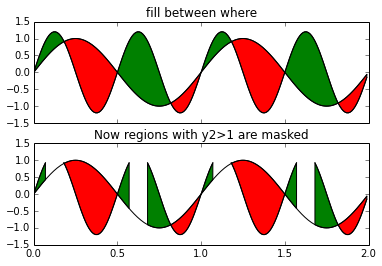

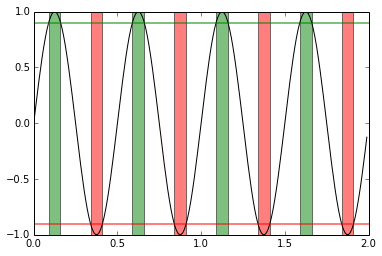

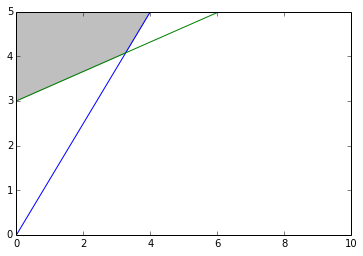